チームわらわら　機械分析

In [103]:
# pip install missingno

In [104]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pandas.plotting import parallel_coordinates
from statsmodels.stats.outliers_influence import variance_inflation_factor

import missingno as msno

リレーショナルデータベースをプライマリーキーのidを使って一つに集約する

In [105]:
df_user = pd.read_csv("user.csv")            # 顧客管理
df_reception = pd.read_csv("reception.csv")  # 接客管理
df_answer = pd.read_csv("answer_info.csv")   # 回答管理

#  answer_info と reception を結合
#  answer_info.reception_id と reception.id をキーに LEFT JOIN (how="left")
df_join1 = pd.merge(
    df_answer,
    df_reception,
    left_on="reception_id",
    right_on="id",     # receptionテーブルのPK
    how="left",
    suffixes=("", "_reception")  # 同名列がある場合のサフィックス指定
)

# 上記の結果と user を結合
# reception.user_id と user.id をキーに LEFT JOIN (how="left")
df_merged = pd.merge(
    df_join1,
    df_user,
    left_on="user_id",
    right_on="id",     # userテーブルのPK
    how="left",
    suffixes=("", "_user")
)

print(df_merged.head())
print(df_merged.columns)
print(df_merged.shape)

   id  reception_id  question_id  answer_numeric  answer_boolean  \
0   1             1            1             NaN             NaN   
1   2             1            2             NaN             1.0   
2   3             1            3             NaN             1.0   
3   4             1            4             NaN             NaN   
4   5             1            5             NaN             1.0   

  answer_categorical  id_reception  user_id  category_id                 time  \
0             3LDK以上             1        1         1000  2025-03-12 02:47:39   
1                NaN             1        1         1000  2025-03-12 02:47:39   
2                NaN             1        1         1000  2025-03-12 02:47:39   
3            どちらもほしい             1        1         1000  2025-03-12 02:47:39   
4                NaN             1        1         1000  2025-03-12 02:47:39   

   id_user  store_id  age  gender  household           time_user  
0        1         1   60       1    

ピボット処理を行い、reception_idごとに1行にまとめるワイドフォーマットへの変換

In [106]:
df_wide_format = df_merged.pivot_table(
                    index="reception_id",
                    columns="question_id",
                    values=["answer_numeric", "answer_boolean", "answer_categorical"],
                    aggfunc="first"
                )
# カラム名を整理（例: "q1_answer_numeric", "q2_answer_boolean" など）
df_wide_format.columns = [f"q{col[1]}_{col[0]}" for col in df_wide_format.columns]
df_wide_format.reset_index(inplace=True)

# df_wide_format は「(reception_id)×(質問回答)」だけを保持
# df_merged から、「reception_id ごとに一意なユーザー情報・接客情報」だけを抽出し、重複しないようにする
# それらを reception_id キーにマージすれば、ユーザー情報 + 回答ワイド形式となる
df_reception_user = df_merged.drop_duplicates("reception_id")[
    ["reception_id", "store_id", "age", "gender", "household", "time_user", "user_id", "category_id", "time"]
]
df_wide_format = pd.merge(df_wide_format, df_reception_user, on="reception_id", how="left")

print(df_wide_format.head())
print(df_wide_format.columns)
print(df_wide_format.shape)


   reception_id  q2_answer_boolean  q3_answer_boolean  q5_answer_boolean  \
0             1                1.0                1.0                1.0   
1             2                0.0                0.0                0.0   
2             3                0.0                1.0                0.0   
3             4                1.0                1.0                1.0   
4             5                0.0                1.0                1.0   

   q6_answer_boolean q1_answer_categorical q4_answer_categorical  \
0                1.0                3LDK以上               どちらもほしい   
1                0.0               1R / 1K                  特になし   
2                1.0             1LDK〜2LDK              スケジュール設定   
3                0.0             1LDK〜2LDK                 エリア設定   
4                1.0             1LDK〜2LDK               どちらもほしい   

   q7_answer_numeric  q8_answer_numeric  q9_answer_numeric  ...  \
0                1.0                5.0                3.0  ...   


分かりやすいようにカラムをリネーム

In [107]:
rename_map = {
    "q1_answer_categorical":  "room_layout",            # (1) ロボット掃除機を使いたい部屋の間取りを教えてください。
    "q2_answer_boolean":      "pet_room",               # (2) ペットを飼っている部屋でロボット掃除機を使いたいですか？
    "q3_answer_boolean":      "carpet_rug",             # (3) お部屋にはカーペットやラグがありますか？
    "q4_answer_categorical":  "app_features",           # (4) ロボット掃除機のアプリで欲しい機能はどれですか？
    "q5_answer_boolean":      "wipe_cleaning",          # (5) 拭き掃除もロボット掃除機に任せたいですか？
    "q6_answer_boolean":      "auto_dustbin",           # (6) 自動ゴミ収集機能が欲しいですか？
    "q7_answer_numeric":      "quiet_mode",             # (7) 吸引力が落ちても静かに掃除して欲しい
    "q8_answer_numeric":      "less_collision",         # (8) 細かい場所の掃除制度は下がっても衝突回数が減る方がいい
    "q9_answer_numeric":      "fully_automated",        # (9) 掃除はロボット掃除機に全て任せたい
    "q10_answer_numeric":     "detailed_suction",       # (10) 部屋全体・部屋の隅・壁際などの細かい場所でもしっかり吸引してほしい？
    "q11_answer_numeric":     "finish_when_away",       # (11) 家にいる時に掃除してくれるよりも、外出中に掃除が終わっている方がいい
    "q12_answer_numeric":     "maintenance_reduction"   # (12) 多少高くてもメンテナンスの手間が減るほどいい
}

# 辞書を用いて列名を置き換え
df_renamed = df_wide_format.rename(columns=rename_map)

print(df_renamed.columns)

Index(['reception_id', 'pet_room', 'carpet_rug', 'wipe_cleaning',
       'auto_dustbin', 'room_layout', 'app_features', 'quiet_mode',
       'less_collision', 'fully_automated', 'detailed_suction',
       'finish_when_away', 'maintenance_reduction', 'store_id', 'age',
       'gender', 'household', 'time_user', 'user_id', 'category_id', 'time'],
      dtype='object')


In [108]:
# q1とq4はカテゴリカルなのでエンコーディング実施
df_encoded = df_renamed.copy()

# q1_answer_categorical（間取り情報）はラベルエンコーディング
le = LabelEncoder()
# 欠損値がある場合は、一旦文字列に変換して埋める（ここでは "missing" として扱う）
df_encoded["room_layout"] = df_encoded["room_layout"].fillna("missing")
df_encoded["room_layout"] = le.fit_transform(df_encoded["room_layout"])


# q4_answer_categorical はワンホットエンコーディング
df_encoded = pd.get_dummies(
    df_encoded, 
    columns=["app_features"], 
    prefix="app_features", 
    dummy_na=True,
    drop_first=True  # 列同士が完全に線形従属になり多重共線性が無限大になってしまうため、１列落とす
)

# timeは2025-03-12 2:47:39の形式なので、これを年、月、日、時間に分割
# timeカラムをdatetime型に変換
df_encoded["time"] = pd.to_datetime(df_encoded["time"])

# 年、月、日、時間のカラムを作成
df_encoded["year"] = df_encoded["time"].dt.year
df_encoded["month"] = df_encoded["time"].dt.month
df_encoded["day"] = df_encoded["time"].dt.day
df_encoded["hour"] = df_encoded["time"].dt.hour

# 新たに曜日のカラムも追加
df_encoded["weekday"] = df_encoded["time"].dt.day_name()  # 例："Monday", "Tuesday", ...

# weekdayカラムをワンホットエンコーディング
df_encoded = pd.get_dummies(
    df_encoded, 
    columns=["weekday"], 
    prefix="weekday",
    drop_first=True
)

# ワンホットエンコーディングの結果がbooleanの場合、0/1の整数に変換
for col in df_encoded.columns:
    if col.startswith(("app_features","weekday_")):
        df_encoded[col] = df_encoded[col].astype(int)

# timeとtime_userのカラムを削除
df_encoded.drop(columns=["time", "time_user"], inplace=True)

print(df_encoded.head(5))

   reception_id  pet_room  carpet_rug  wipe_cleaning  auto_dustbin  \
0             1       1.0         1.0            1.0           1.0   
1             2       0.0         0.0            0.0           0.0   
2             3       0.0         1.0            0.0           1.0   
3             4       1.0         1.0            1.0           0.0   
4             5       0.0         1.0            1.0           1.0   

   room_layout  quiet_mode  less_collision  fully_automated  detailed_suction  \
0            2         1.0             5.0              3.0               5.0   
1            1         4.0             2.0              4.0               2.0   
2            0         3.0             4.0              2.0               3.0   
3            0         4.0             3.0              3.0               3.0   
4            0         2.0             5.0              2.0               4.0   

   ...  year  month  day  hour  weekday_Monday  weekday_Saturday  \
0  ...  2025      3   12

id類（user_id、category_id、reception_id）はリーケージの原因となりえるため、すべて削除する

In [109]:
df_encoded = df_encoded.drop(columns=["user_id", "category_id", "reception_id"], errors="ignore")

データの可視化を実行
単変量可視化

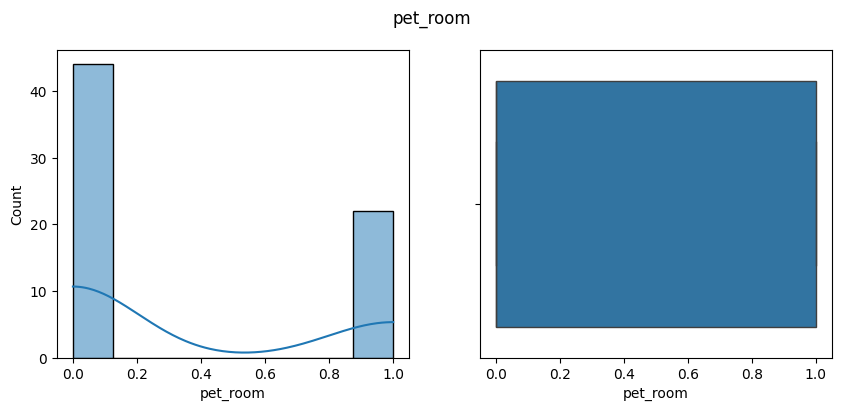

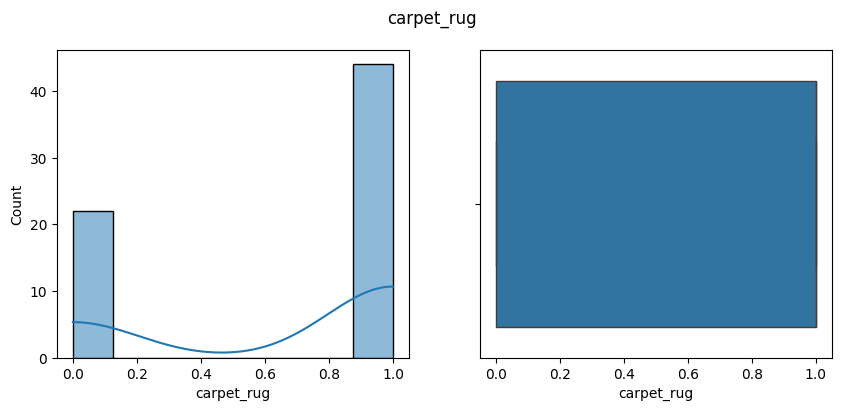

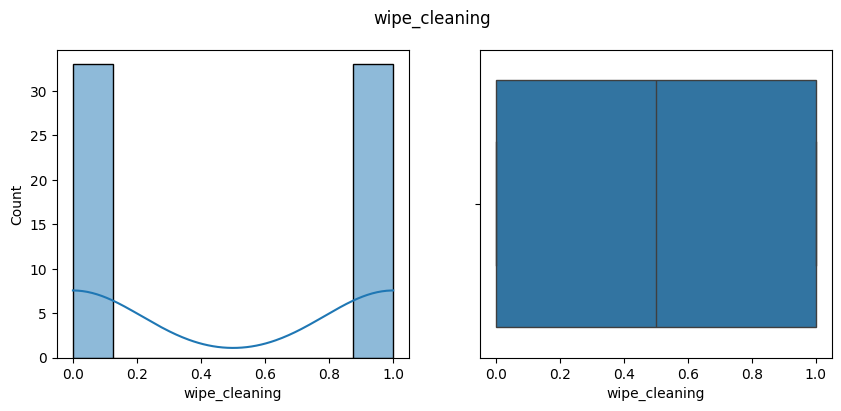

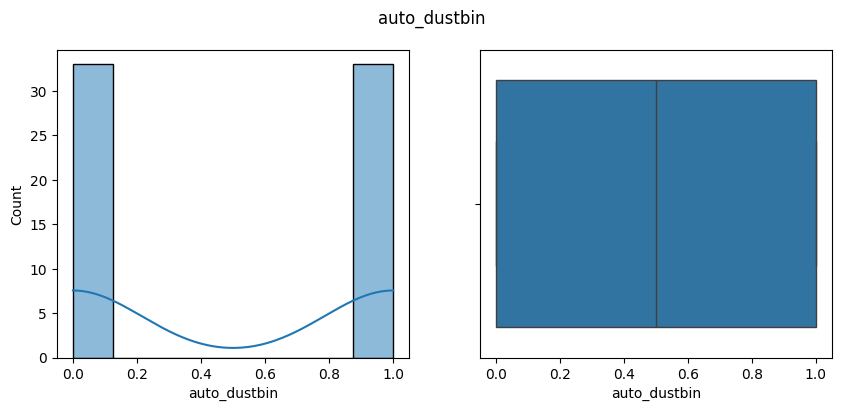

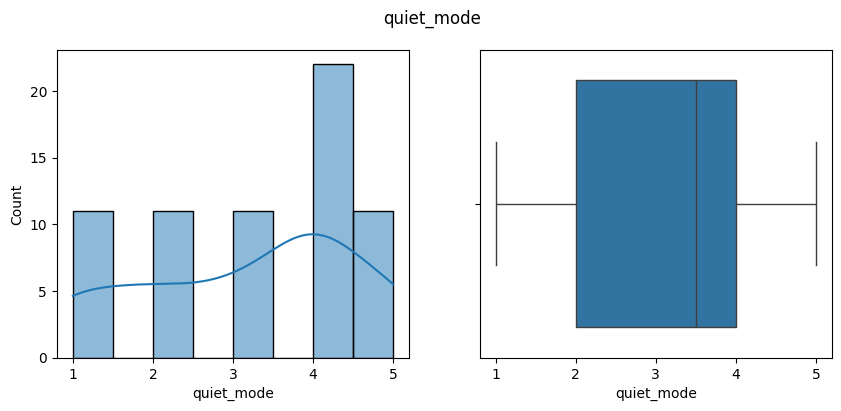

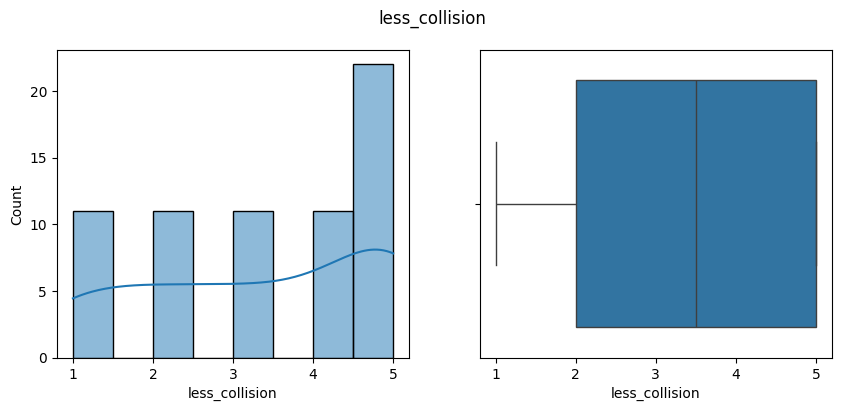

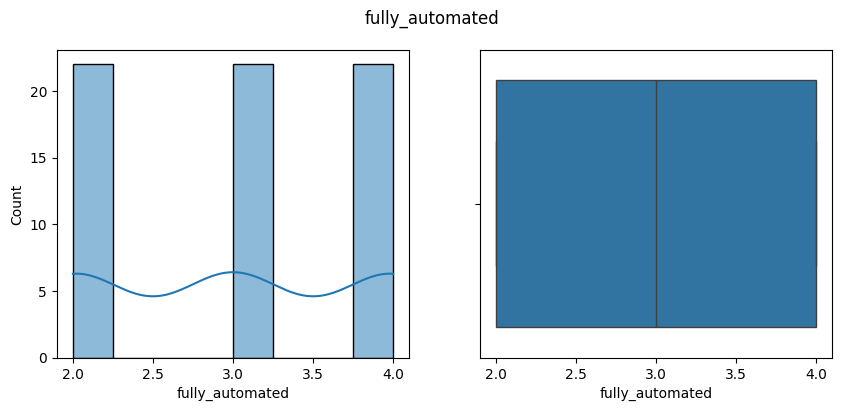

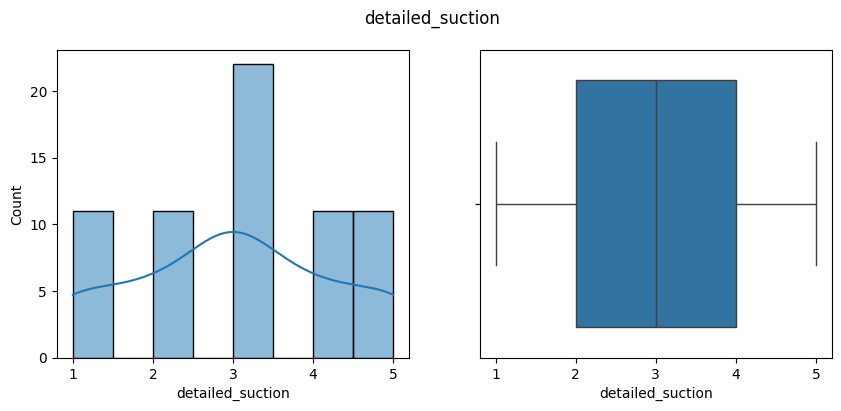

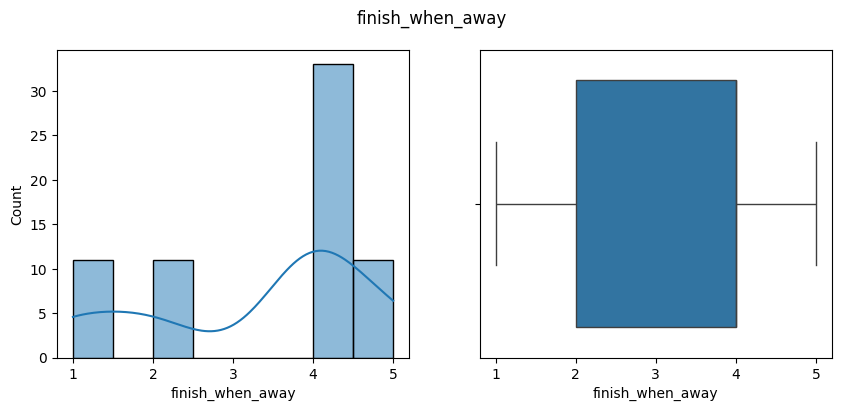

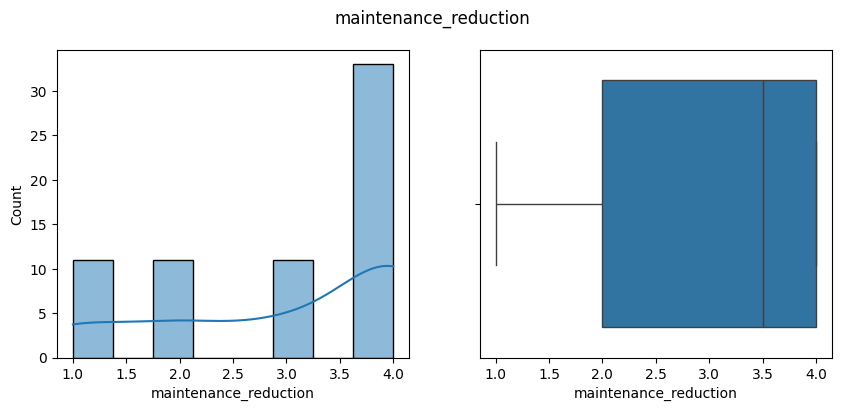

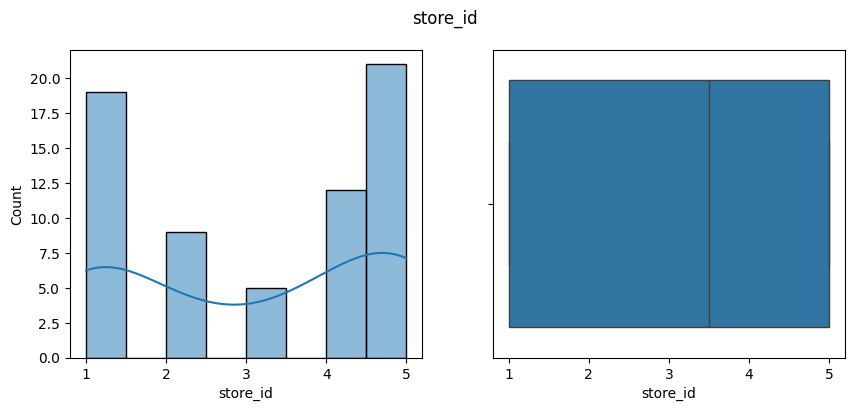

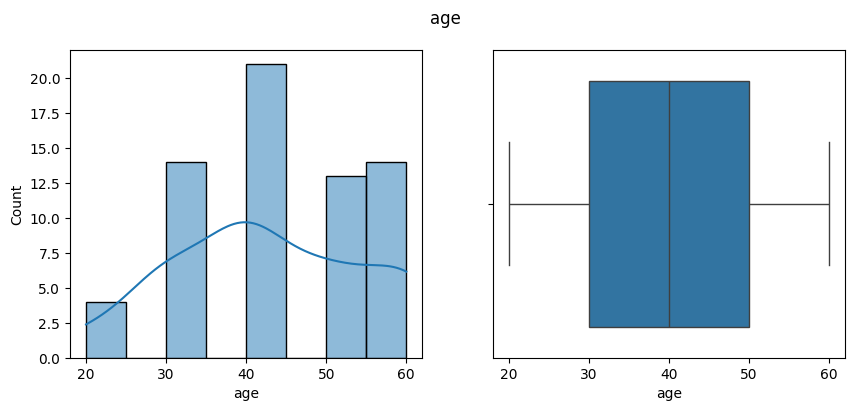

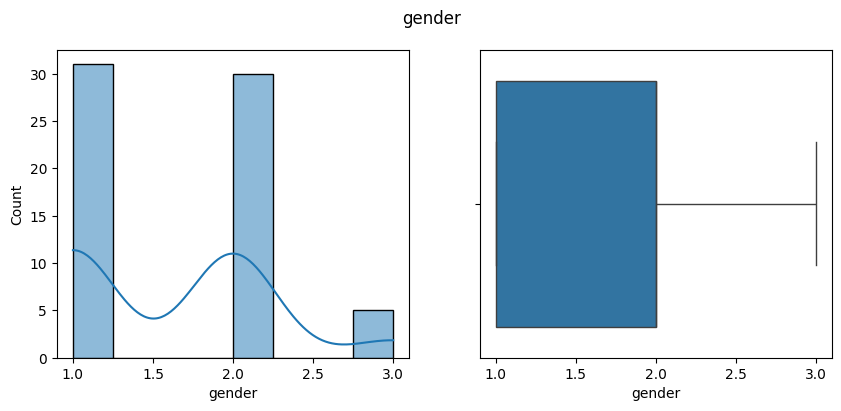

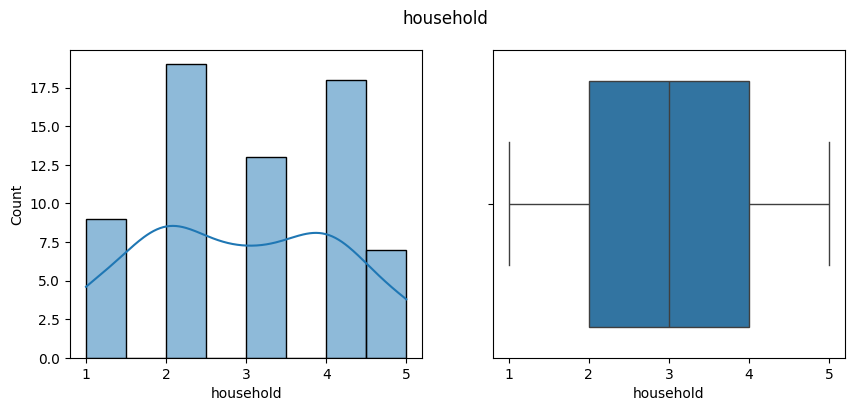

In [110]:
numeric_cols = df_encoded.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df_encoded[col].dropna(), ax=axes[0], kde=True)
    sns.boxplot(x=df_encoded[col], ax=axes[1])
    plt.suptitle(col)
    plt.show()

二変量可視化（相関ヒートマップ）


c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c

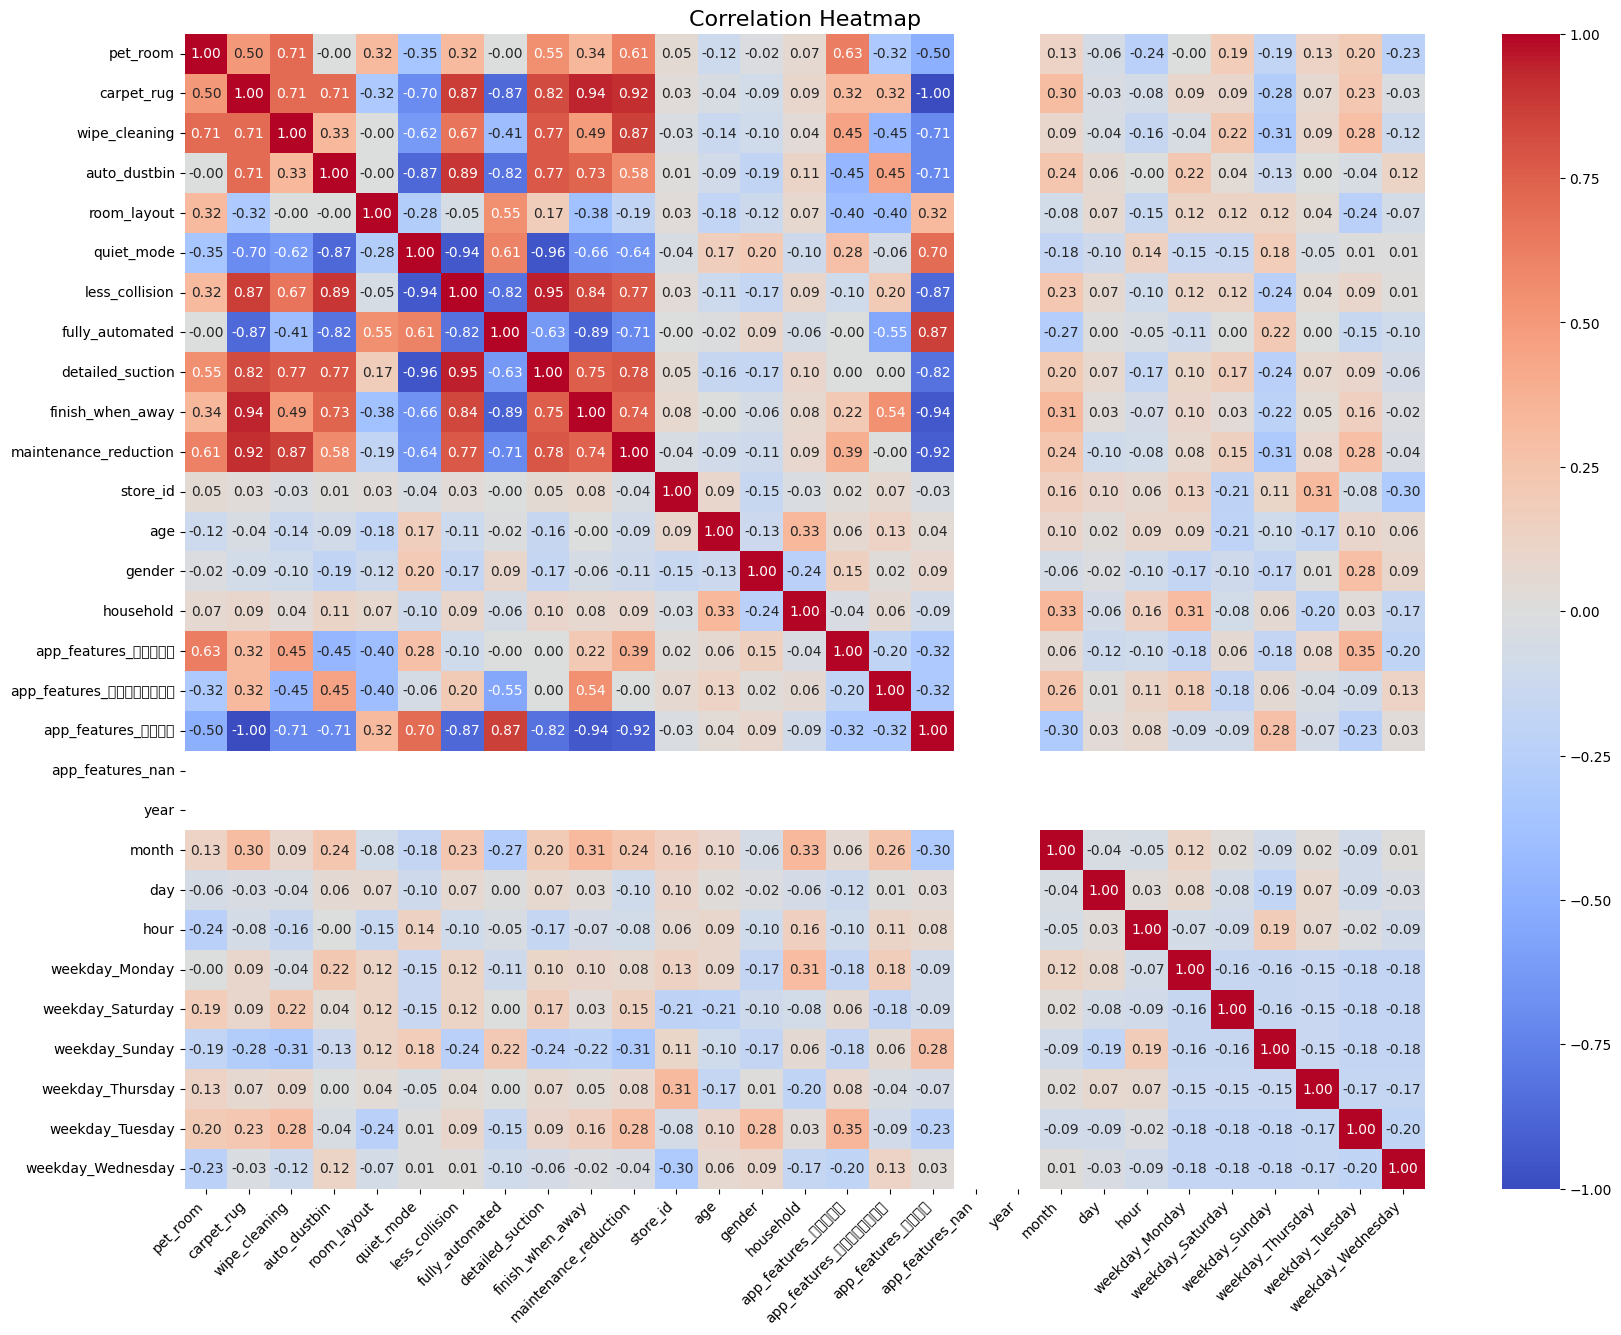

In [123]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right")  # X軸ラベルを45度回転させて重なりを防ぐ
plt.yticks(rotation=0)               # Y軸は水平のままにする
plt.show()

多重共線性の確認（VIFの計算）。VIFは回帰の説明変数行列に対して計算するので、定数項を付与して行う。定数項（const）のVIFが高いのは、ダミー変数などとの線形依存が原因であり、統計的にもよく起こる現象。多重共線性の問題は「説明変数同士の相関」が本質なので、定数項はVIF計算から除外して考える

In [112]:
X = df_encoded.copy()  # 必要に応じて除外する列があれば落とす
# 定数項const=1を追加。定数項を含めずにVIFを計算すると、回帰が「原点を通る」形になり、
# 実際の回帰モデル（切片付き）とは異なる設定になってしまう。
# 回帰モデルでは通常、切片（定数項）を含めて回帰を行うため、VIF計算でも同じく定数項を含んだデザイン行列を用いる
X = X.assign(const=1)

vif_data = []
for i in range(X.shape[1]):
    col_name = X.columns[i]
    vif_value = variance_inflation_factor(X.values, i)
    vif_data.append((col_name, vif_value))

# DataFrameにしてVIFを降順表示
vif_df = pd.DataFrame(vif_data, columns=["Variable", "VIF"]).sort_values("VIF", ascending=False)
print(vif_df)

                 Variable       VIF
0                pet_room       inf
8        detailed_suction       inf
17      app_features_特になし       inf
16  app_features_スケジュール設定       inf
15     app_features_エリア設定       inf
1              carpet_rug       inf
9        finish_when_away       inf
10  maintenance_reduction       inf
7         fully_automated       inf
6          less_collision       inf
5              quiet_mode       inf
4             room_layout       inf
3            auto_dustbin       inf
2           wipe_cleaning       inf
28      weekday_Wednesday  2.582554
27        weekday_Tuesday  2.540375
23         weekday_Monday  2.429366
25         weekday_Sunday  2.324960
24       weekday_Saturday  2.319269
26       weekday_Thursday  2.155726
14              household  1.730336
11               store_id  1.510194
20                  month  1.441006
12                    age  1.439239
13                 gender  1.396128
22                   hour  1.278577
21                    day  1

c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


多変量可視化（PCA, t-SNE）
ワイドフォーマットのデータ（df_wide_format）から数値データだけを取り出し、欠損値のある行を除外した上で、PCAとt-SNEという次元削減手法を用いてデータを2次元に圧縮し、可視化

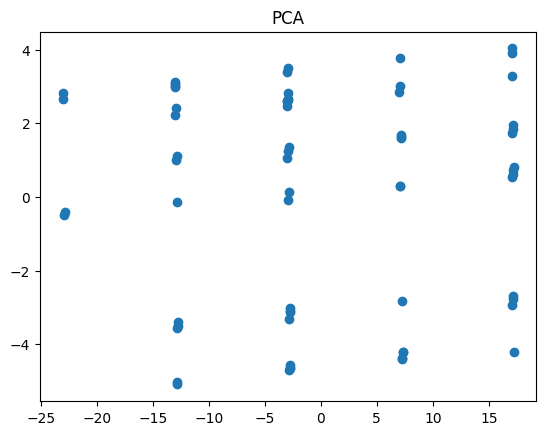

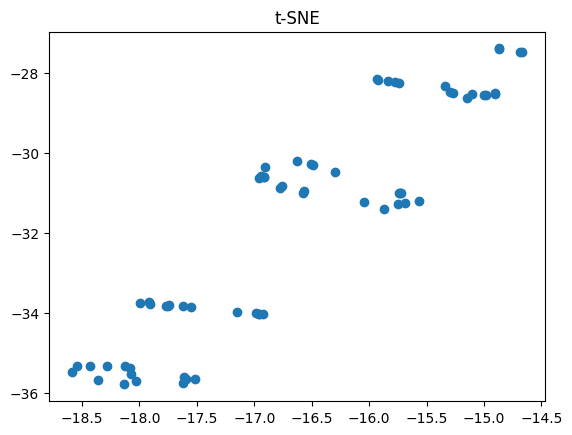

In [113]:
# 数値型のカラムだけを抽出
df_num = df_encoded.select_dtypes(include=['int64','float64']).dropna()

# PCA（主成分分析）を用いて、元の多次元データを2つの主成分に圧縮します。
# 得られた2次元のデータを散布図にプロットすることで、データ全体の大まかな構造や潜在的なクラスタが視覚的に確認できる
pca = PCA(n_components=2).fit_transform(df_num)
plt.scatter(pca[:,0], pca[:,1])
plt.title("PCA")
plt.show()

# t-SNE（t分布型確率的近傍埋め込み）は、局所的な構造をうまく保持する次元削減手法です。
# 同様に2次元に変換したデータを散布図にプロットし、細かなクラスタリングの兆候などを視覚的に把握
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_num)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("t-SNE")
plt.show()

欠損可視化

In [114]:
# msno.matrix(df_encoded)
# plt.show()
# msno.heatmap(df_encoded)
# plt.show()

KMeansでクラスタリング

In [115]:
#  クラスタリング用に数値型のカラムだけを抽出（欠損値のある行は除外）
df_numeric = df_encoded.select_dtypes(include=['int64','float64']).dropna()

# reception_idを除外してクラスタリング用のDataFrameを作成
# reception_idが極端に大きな値のため除外
df_for_cluster = df_numeric.drop(columns=['reception_id'], errors='ignore')

#  KMeansでクラスタリング（例：クラスタ数3）
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_for_cluster)
df_for_cluster['cluster'] = clusters.astype(str)  # 色分けのため文字列に変換


ペアプロットの作成（KMeansのクラスタごとに色分け）適当にクラスタ数は3に設定

In [116]:
# sns.pairplot(df_for_cluster, hue='cluster', diag_kind='hist')
# plt.suptitle("Pair Plot with Cluster Colors", y=1.02)
# plt.show()

平行座標プロットの作成（KMeansのクラスタごとに色分け）
どの質問がグループの違いに影響しているかを探る

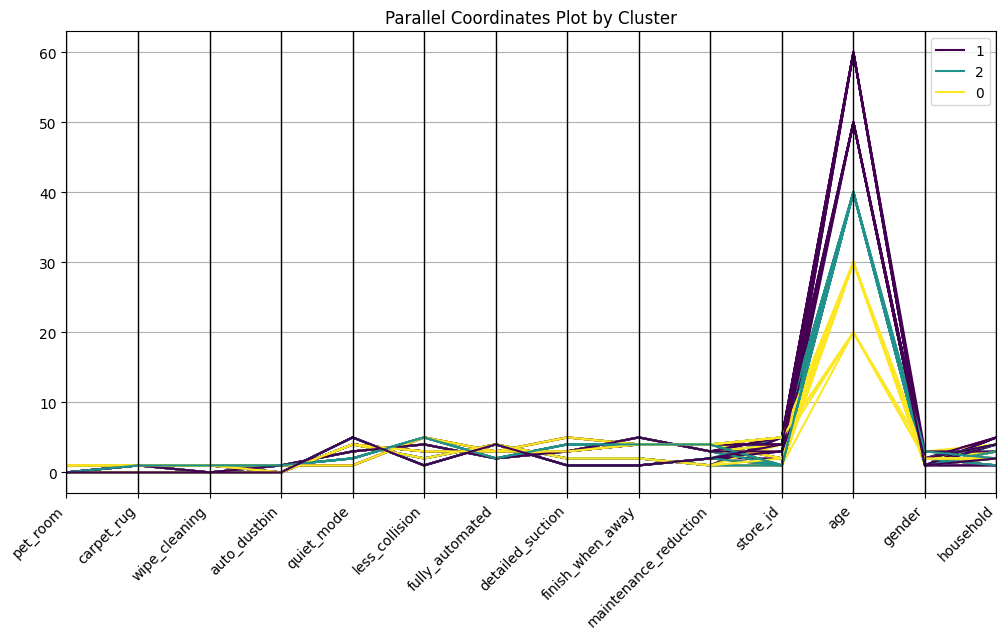

In [117]:
plt.figure(figsize=(12,6))
parallel_coordinates(df_for_cluster.reset_index(drop=True), class_column='cluster', colormap='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Parallel Coordinates Plot by Cluster")
plt.show()

MeanShift（教師なし学習）

In [118]:
# バンド幅の推定
bandwidth = estimate_bandwidth(df_for_cluster, quantile=0.2, n_samples=500)
# クラスタリング実行
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df_for_cluster)

labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ms = len(np.unique(labels_ms))

print(f"MeanShiftの推定クラスタ数: {n_clusters_ms}")

# クラスタ結果をDataFrameに付与
# カラムcluster_msはMeanShiftの結果を反映
df_for_cluster["cluster_ms"] = labels_ms

print(df_for_cluster.head())

MeanShiftの推定クラスタ数: 4
   pet_room  carpet_rug  wipe_cleaning  auto_dustbin  quiet_mode  \
0       1.0         1.0            1.0           1.0         1.0   
1       0.0         0.0            0.0           0.0         4.0   
2       0.0         1.0            0.0           1.0         3.0   
3       1.0         1.0            1.0           0.0         4.0   
4       0.0         1.0            1.0           1.0         2.0   

   less_collision  fully_automated  detailed_suction  finish_when_away  \
0             5.0              3.0               5.0               4.0   
1             2.0              4.0               2.0               2.0   
2             4.0              2.0               3.0               5.0   
3             3.0              3.0               3.0               4.0   
4             5.0              2.0               4.0               4.0   

   maintenance_reduction  store_id  age  gender  household cluster  cluster_ms  
0                    4.0         1   60     

BayesianGaussianMixture (VBGMM)（教師なし学習）

In [119]:
# n_componentsは最大クラスタ数の上限。これを変えるとクラスタ数が変化する
# クラスタ数を可変にするための変数を用意
n_clusters = 10
bgmm = BayesianGaussianMixture(n_components=n_clusters, random_state=42)  
bgmm.fit(df_for_cluster.drop(columns=["cluster_ms"], errors="ignore"))    # すでにcluster_msを付与している場合は除外
labels_bgmm = bgmm.predict(df_for_cluster.drop(columns=["cluster_ms"], errors="ignore"))

df_for_cluster["cluster_bgmm"] = labels_bgmm.astype(str)

#  n_clustersに合わせて自動でカラーパレットを生成
palette = sns.color_palette("Set2", n_clusters)

可視化（例: PCAで2次元に圧縮して散布図）
MeanShiftと VBGMMの結果をそれぞれ表示

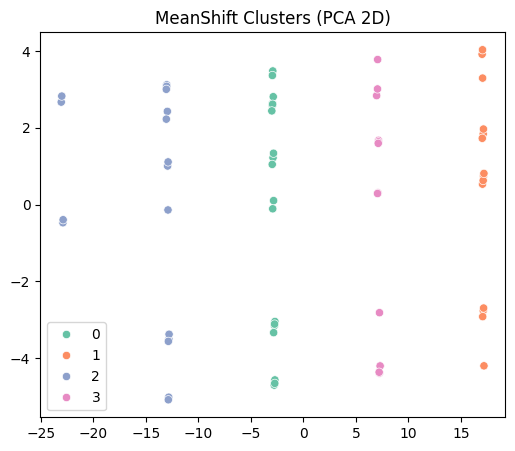

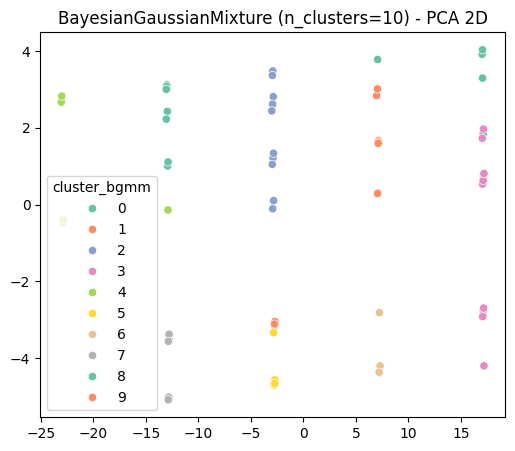

In [120]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_for_cluster.drop(columns=["cluster_ms","cluster_bgmm"], errors="ignore"))

# MeanShiftの結果を色分け表示
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels_ms, palette="Set2")
plt.title("MeanShift Clusters (PCA 2D)")
plt.legend()
plt.show()

# VBGMMの結果を色分け表示
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=pca_result[:,0], 
    y=pca_result[:,1], 
    hue=df_for_cluster["cluster_bgmm"], 
    palette=palette,
    hue_order=[str(i) for i in range(n_clusters)]  # 0,1,2,... の順序を固定
)
plt.title(f"BayesianGaussianMixture (n_clusters={n_clusters}) - PCA 2D")
plt.show()

VBGMMの結果から並行座標プロットを作成してみる。
VBGMMのクラスタ数を変更すると描画が変わる

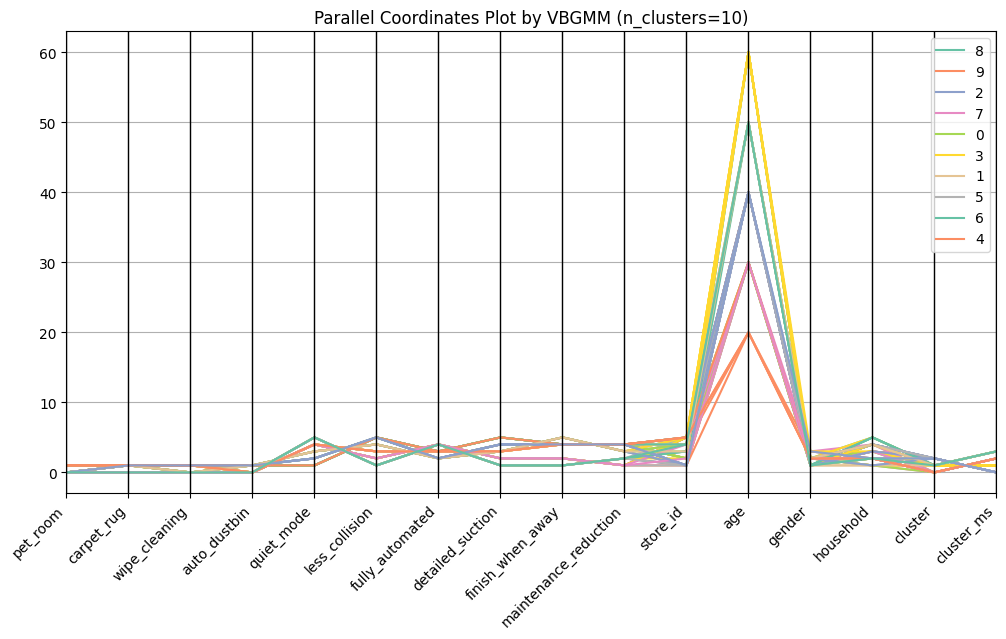

In [121]:
#   クラスタラベルの順序を [str(i) for i in range(n_clusters)] に固定
df_for_cluster["cluster_bgmm"] = pd.Categorical(
    df_for_cluster["cluster_bgmm"],
    categories=[str(i) for i in range(n_clusters)],
    ordered=True
)

#   - class_column='cluster_bgmm' でクラスタラベルを色分け
#   - reset_index(drop=True) でインデックスを連番にリセット（描画上の不要な混乱を避ける）
plt.figure(figsize=(12,6))
parallel_coordinates(
    df_for_cluster.reset_index(drop=True),
    class_column='cluster_bgmm',
    color=palette,  # VBGMMと同じパレットを利用
    sort_labels=False
)
plt.xticks(rotation=45, ha='right')
plt.title(f"Parallel Coordinates Plot by VBGMM (n_clusters={n_clusters})")
plt.show()

VBGMMのクラスタラベルを疑似的な「目的変数」として分類モデルを作成。擬似的に「どの特徴量がクラスタ分割に寄与しているか」を可視化する。

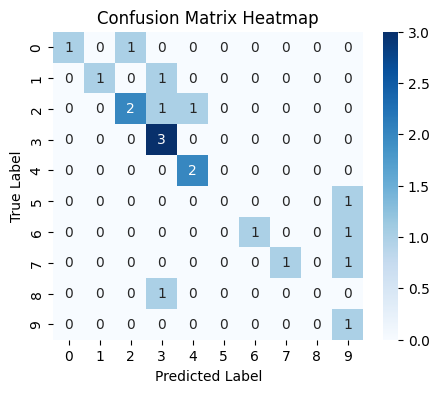

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      0.50      0.67         2
           2       0.67      0.50      0.57         4
           3       0.50      1.00      0.67         3
           4       0.67      1.00      0.80         2
           5       0.00      0.00      0.00         1
           6       1.00      0.50      0.67         2
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         1
           9       0.25      1.00      0.40         1

    accuracy                           0.60        20
   macro avg       0.61      0.55      0.51        20
weighted avg       0.69      0.60      0.58        20

Feature Importances:
age                      0.338606
household                0.116076
store_id                 0.100872
gender                   0.069059
less_collision           0.067065
detailed_suction         0.062539
quiet_mode      

c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [122]:
# クラスタラベルを疑似的な目的変数 (y) とし、特徴量 (X) として使うデータを準備
X = df_for_cluster.drop(columns=["cluster", "cluster_bgmm", "cluster_ms"], errors="ignore").copy()
y = labels_bgmm  # VBGMMのクラスタラベルを疑似的な目的変数とする

# 擬似的な教師あり学習データの作成
#  学習データとテストデータに分割 (今回は学習データ7、テストデータ3と設定)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

#  ランダムフォレストで学習
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#  テストデータで評価
y_pred = clf.predict(X_test)

#  混同行列を取得
cm = confusion_matrix(y_test, y_pred)

#  ヒートマップで可視化
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


print(classification_report(y_test, y_pred))

#  特徴量重要度を確認
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)